In [2]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [3]:
mean_gray=0.1307
stddev_gray=0.3081

transforms=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean_gray,),(stddev_gray))
])
train_dataset=datasets.MNIST(root='./data',train=True,transform=transforms,download=True)
test_dataset=datasets.MNIST(root='./data',train=False,transform=transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



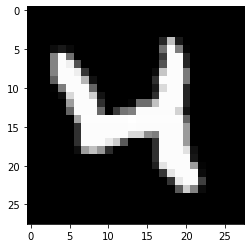

In [4]:
import matplotlib.pyplot as plt
import numpy as np
random_img=train_dataset[20][0].numpy()*stddev_gray+mean_gray
img=np.transpose(random_img,(1,2,0))
plt.imshow(img,cmap='gray')

In [5]:
batch_size=100
train_load=torch.utils.data.DataLoader(dataset=train_dataset,
                                       batch_size=batch_size,
                                       shuffle=True
                                      )
test_load=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False)

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn1=nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,stride=1,padding=1)
        #(B,8,28,28)
        self.relu=nn.ReLU()
        self.maxpool=nn.MaxPool2d(kernel_size=2)
        #(B,8,14,14)
        self.cnn2=nn.Conv2d(8,16,kernel_size=3,padding=1,stride=1)
        #(B,16,14,14)
        self.batchnorm=nn.BatchNorm2d(16)
        #After maxpooling (B,16,7,7)
        #Flatten: 16*7*7
        self.fc1=nn.Linear(16*7*7,400)
        self.dropout=nn.Dropout(p=0.5)
        self.fc2=nn.Linear(400,10)
        
    def forward(self,x):
        
        out=self.cnn1(x)
        #(8,28,28)
        #print(out.shape)
        out=self.relu(out)
        out=self.maxpool(out)
        #print(out.shape)
        #(8,14,14)
        out=self.cnn2(out)
        #print(out.shape)
        #(16,14,14)
        out=self.batchnorm(out)
        out=self.relu(out)
        out=self.maxpool(out)
       # print(out.shape)
        #(16,7,7)
        
        out=out.view(-1,16*7*7)
       # print(out.shape)
        out=self.fc1(out)
       # print(out.shape)
        out=self.dropout(out)
        out=self.fc2(out)
        #print(out.shape)
        return out

In [20]:
model=CNN()

In [21]:
CUDA=torch.cuda.is_available()
if CUDA:
    model=model.cuda()


In [22]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)

In [10]:
iteration=0
correct=0

for i,(inputs,labels) in enumerate(train_load):
    if CUDA:
        inputs=inputs.cuda()
        labels=labels.cuda()
    
    print('Fore one iteration,this is what it happens:')
    print('Input Shape:',inputs.shape)
    print('Labels Shape',labels.shape)
    with torch.no_grad():
        output=model(inputs)
    print('Output shape',output.shape)
    _,predicted=torch.max(output,1)
    print('Predicted shape',predicted.shape)
    print(predicted)
    correct+=(predicted==labels).sum()
    break
    


Fore one iteration,this is what it happens:
Input Shape: torch.Size([100, 1, 28, 28])
Labels Shape torch.Size([100])
Output shape torch.Size([100, 10])
Predicted shape torch.Size([100])
tensor([6, 8, 8, 6, 9, 6, 8, 6, 8, 6, 0, 6, 6, 5, 7, 5, 9, 9, 8, 8, 1, 8, 8, 9,
        4, 8, 1, 8, 8, 5, 5, 8, 8, 8, 8, 8, 0, 6, 9, 5, 2, 2, 8, 9, 2, 0, 9, 6,
        8, 1, 8, 6, 7, 6, 9, 5, 8, 0, 3, 8, 6, 8, 6, 9, 6, 8, 8, 0, 6, 8, 6, 8,
        6, 8, 2, 1, 8, 8, 1, 2, 9, 6, 0, 8, 0, 2, 4, 9, 8, 9, 6, 8, 6, 6, 8, 5,
        8, 8, 6, 6], device='cuda:0')


In [23]:
num_epochs=10
train_loss=[]
train_accuracy=[]
testing_loss=[]
test_accuracy=[]

for epoch in range(num_epochs):
    correct=0
    iterations=0
    iter_loss=0.0
    
    model.train()
    
    for i,(inputs,labels) in enumerate(train_load):
        if CUDA:
            inputs=inputs.cuda()
            labels=labels.cuda()
        output = model(inputs)
        loss= loss_fn(output,labels)
        
        iter_loss+=loss.item()
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        _,predicted=torch.max(output,1)
        correct+=(predicted==labels).sum().item()
        iterations+=1
    train_loss.append(iter_loss/iterations)
    train_accuracy.append(100*correct/len(train_dataset))
    
    #Testing Phase:
    test_loss=0.0  
    correct=0
    iterations=0
    
    model.eval()
    
    for idx,(inputs,labels) in enumerate(test_load):
        if CUDA:
            inputs=inputs.cuda()
            labels=labels.cuda()
        
        outputs=model(inputs)
        loss=loss_fn(outputs,labels)
        test_loss+=loss.item()
            
        _,predictions=torch.max(outputs,1)
        correct+=(predictions==labels).sum().item()
        iterations+=1
    print(iterations)    
    testing_loss.append(test_loss/iterations)
    test_accuracy.append((100*correct/len(test_dataset)))
    print("Epoch {}/{}, Training Loss :{:,.3f}, Training Accuracy: {:.3f}, Testing Loss:{:.3f},Testing Accuracy:{:.3f}".format(epoch+1,num_epochs,train_loss[-1],train_accuracy[-1],testing_loss[-1],test_accuracy[-1]))

100
Epoch 1/10, Training Loss :0.460, Training Accuracy: 92.627, Testing Loss:0.067,Testing Accuracy:97.650
100
Epoch 2/10, Training Loss :0.084, Training Accuracy: 97.463, Testing Loss:0.060,Testing Accuracy:98.030
100
Epoch 3/10, Training Loss :0.075, Training Accuracy: 97.640, Testing Loss:0.051,Testing Accuracy:98.390
100
Epoch 4/10, Training Loss :0.070, Training Accuracy: 97.795, Testing Loss:0.052,Testing Accuracy:98.410
100
Epoch 5/10, Training Loss :0.074, Training Accuracy: 97.697, Testing Loss:0.053,Testing Accuracy:98.280
100
Epoch 6/10, Training Loss :0.073, Training Accuracy: 97.810, Testing Loss:0.053,Testing Accuracy:98.330
100
Epoch 7/10, Training Loss :0.072, Training Accuracy: 97.897, Testing Loss:0.082,Testing Accuracy:97.960
100
Epoch 8/10, Training Loss :0.076, Training Accuracy: 97.780, Testing Loss:0.070,Testing Accuracy:97.990
100
Epoch 9/10, Training Loss :0.080, Training Accuracy: 97.773, Testing Loss:0.068,Testing Accuracy:98.260
100
Epoch 10/10, Training Lo

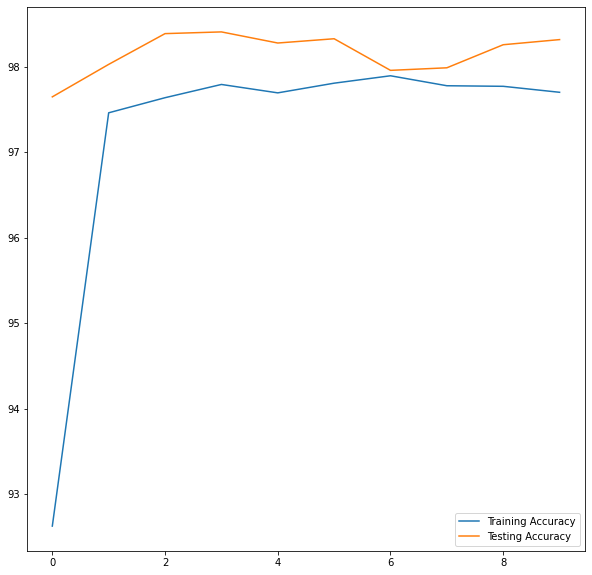

In [24]:
f=plt.figure(figsize=(10,10))
plt.plot(train_accuracy,label='Training Accuracy')
plt.plot(test_accuracy,label='Testing Accuracy')
plt.legend()
plt.show()

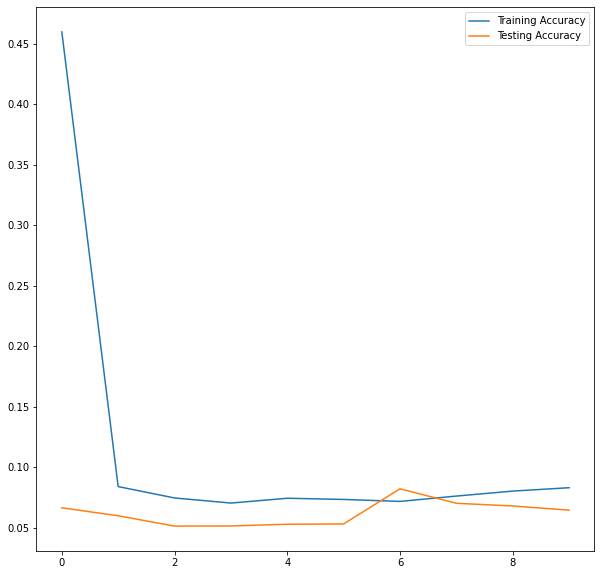

In [25]:
f=plt.figure(figsize=(10,10))
plt.plot(train_loss,label='Training Accuracy')
plt.plot(testing_loss,label='Testing Accuracy')
plt.legend()
plt.show()

In [57]:
img=test_dataset[30][0].resize_((1,1,28,28))
img.shape

torch.Size([1, 1, 28, 28])

In [58]:
label=test_dataset[30][1]

In [35]:
model.eval()
if CUDA:
    model=model.cuda()
    img=img.cuda()
with torch.no_grad():
    outputs=model(img)
    _,predicted=torch.max(outputs,1)
print('Predictions is : {}'.format(predicted.item()))
print('Actual is {}'.format(label))

Predictions is : 3
Actual is 3


In [36]:
un_normalized_image=img*stddev_gray+mean_gray



In [41]:
un_normalized_image=un_normalized_image.cpu()
un_normalized_image=np.squeeze(un_normalized_image,0)

un_normalized_image.shape

torch.Size([1, 28, 28])

In [42]:
un_normalized_image=np.squeeze(un_normalized_image,0)

In [43]:
un_normalized_image.shape

torch.Size([28, 28])

In [44]:
un_normalized_image=un_normalized_image.numpy()

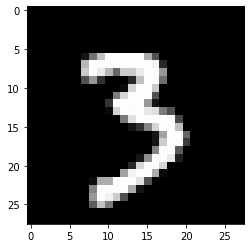

In [46]:
plt.imshow(un_normalized_image,cmap='gray')
plt.show()

In [54]:
torch.save(model.state_dict(),'./model.pth')

In [55]:
model=CNN()
model.load_state_dict(torch.load('./model.pth'))

<All keys matched successfully>

In [56]:
model.eval()

CNN(
  (cnn1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=400, out_features=10, bias=True)
)

In [59]:
model.eval()
if CUDA:
    model=model.cuda()
    img=img.cuda()
with torch.no_grad():
    outputs=model(img)
    _,predicted=torch.max(outputs,1)
print('Predictions is : {}'.format(predicted.item()))
print('Actual is {}'.format(label))

Predictions is : 3
Actual is 3
